bibliotecas que utilizaremos:

1) selenium: para fazer a automação de ações, como clicks, rolagens, ect...
    
2) pandas: precisaremos trabalhar com dataframes.

3) seaborn: plotaegem e estilização dos gráficos.

4) matplotlib: plotagem de gráficos.
    
5) time: algumas vezes,precisaremos dar um curto tempo de espera entre ações.

6) os: biblioteca para acessarmos pastas e arquivos locais.

In [252]:
from selenium import webdriver

from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import time
import os

sns.set()
%matplotlib inline

Como costumo usar o google chrome, utilizarei o chromedriver do selenium.
Perceba que dentro dos parênteses estou passando o caminho do meu chromedriver, que atualmente está na mesma pasta do arquivo .ipynb que estou fazendo esse scraping.
Aqui é importante deixar claro que quando você for fazar o download do webedriver, lembre-se de baixar a versão compatível com a versão do seu navegador.
Estou utilizando a versão 74 do chromedriver pois meu chrome está na versão 74.

Iniciamos criando uma instância do objeto webdriver e logo em seguida já passamos a url que queremos acessar.
Com essa url iremos cair na página inicial do google trends BR, ou seja, por padrão as pesquisas já serão feitas a partir do Brasil, afinal estou acessando o site do Brasil.
Após acessar a página requirida, daremos um 'sleep' para evitar que o nosso programa execute a próxima instrução sem antes carregar o conteúdo da página.
Obs: claro que tudo depende da sua internet, mas como estou utilizando uma de 100MB a requisição e o completo carregamento da página não nescessitarão de mais de um segundo.

Em seguida, temos a função que requisita ao usuário o nome que ele deseja pesquisar no google trends.
Obs: perceba que forçamos a entrada para ser do tipo string(str), fazendo um cast.

In [253]:
# função para requisitar o termo a ser pesquisado
def pesquisa():
    
    pesquisa=str(input("Digite o que deseja pesquisar... \n"))
    entrada = '%20'.join(pesquisa.split())
    
    return entrada, pesquisa

Por algum motivo a página inicial não permite o chromedriver de achar o input de pesquisa inicial, então iremos pesquisar diretamente na url.
Fazendo alguns testes percebi que o padrão de url de uma pesquisa no google trends BR é dado pelo seguinte termo :
'https://trends.google.com.br/trends/explore?geo=BR&q=SUA%20PESQUISA%20VEM%20AQUI'

Logo , podemos pegar o a nossa entrada de usuário e substituir os espaços por '%20'.
Se a string não tiver espaços, é só colocá-la do mesmo jeito.

O código que fiz abaixo se encarrega de tratar os dois tipos de caso citados acima, tanto com espaço ou sem ele.

A função split transforma uma string em uma lista de termos presentes nessa string, se não passarmos nenhum parâmetro para ela - como no caso acima -, então ela toma o espaço como padrão de separação.

A função join coloca alguma string - '%20' no nosso caso- entre os termos de uma lista.

In [254]:
# função que retorna o arqivo mais recente em uma página
def arquivo_recente(path):
    files = os.listdir(path) # lista o nome dos arquivos na pasta
    paths = [os.path.join(path, name) for name in files] # retorna o caminho completo de cada arquivo

    return max(paths, key=os.path.getctime) #retorna o caminho do arquivo mais recente na pasta

A função acima recebe uma pasta e retorna o caminho do arquivo mais recente dentro desta pasta.
Iremos usá-la para pegar os dois arquivos .csv baixados no nosso chromedriver.
Estamos usando isso para evitar uma dependência de nomes de arquivos.
Então, toda vez que eu baixar um csv, o próximo passo é salvar este arquivo em um dataframe.

In [255]:
def plotar(df , op , pesquisa):
    df.dropna(inplace=True) # apagar dados faltantes no dataframe
    
    if op=='geo':
        df.pontuaçao=df.pontuaçao.astype(np.int32) # mudar o tipo da variavel pontuação para int

        plt.figure(figsize=(15,6));
        g=sns.barplot(data=df ,x='estado', y='pontuaçao' , palette="mako")
        g.set_xticklabels(df.estado , rotation=270, fontsize=13 )
        g.set_yticklabels(range(0,101,10),fontsize=14 )
        g.set_yticks(range(0,101,10))
        g.set_title(" '{}' : PONTUAÇÃO POR ESTADO".format(pesquisa), fontsize=14);
    
    elif op=='timeline':
        df.pontuaçao=df.pontuaçao.astype(np.int32) # mudar o tipo da variavel pontuação para int

        plt.figure(figsize=(15,6))
        g=sns.lineplot(x='data', y='pontuaçao', data=df , color='coral', lw=4)
        g.set_xticklabels(df.data, rotation=270, fontsize=13 )
        g.set_yticklabels(range(0,101,10),fontsize=14 )
        g.set_yticks(range(0,101,10))
        g.set_title(" '{}' : ULTIMOS 12 MESES (BRASIL)".format(pesquisa), fontsize=14);
        
    else:
        print("opção inválida... \n")

In [256]:
# pegar a pasta de Downloads de cada usuário
download_path = '/'.join(os.getcwd().split('/')[:3]) + '/Downloads/'

In [257]:
# obter termo
termo,pesquisa = pesquisa() 

Digite o que deseja pesquisar... 
DATA SCIENCE


In [258]:
driver = webdriver.Chrome('./chromedriver')
#driver.fullscreen_window() #maximize window
driver.get('https://trends.google.com.br/trends/?geo=BR')
time.sleep(0.5)

In [259]:
#acessar o termo de pesquisa
try:
    # fazer a pesquisa
    driver.get('https://trends.google.com.br/trends/explore?geo=BR&q={}'.format(termo))
    #esperar a página carregar
    time.sleep(1)

except Exception as e:
    print(e)
    pass

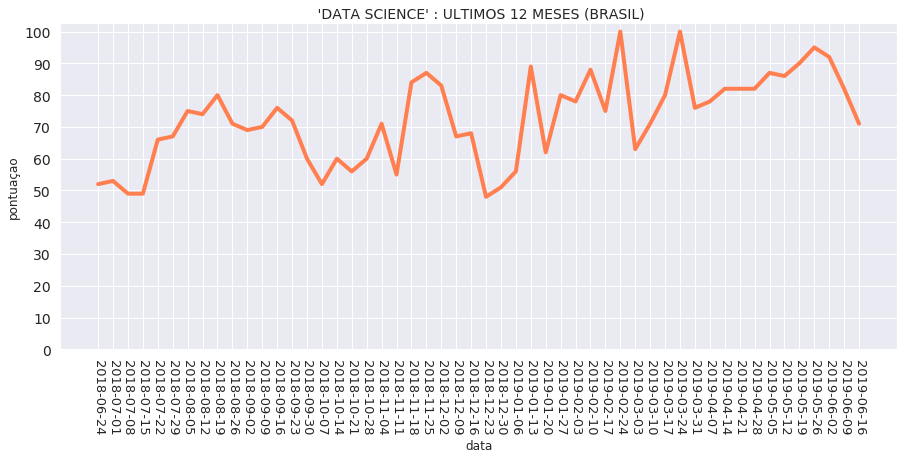

In [260]:
#baixar primeiro csv e plotar
try:
    #clicar no primeiro botão do tipo 'baixar csv'
    first_button = driver.find_elements_by_xpath("""//*[@class="widget-actions-item export"]""")[0]
    first_button.click()

    #esperar baixar o .csv
    time.sleep(1)

    # obter o arquivo mais recente na pasta Downloads
    csv1 = arquivo_recente(download_path)

    #instanciar o primeiro dataframe passando o caminho do csv mais recente
    DF_TIMELINE = pd.read_csv(csv1, names=['data','pontuaçao']).iloc[2:].reset_index(drop=True)

    #plotar gráfico timeline (ultimos 12 meses, por padrão)
    if DF_TIMELINE.shape[0] != 0:   
        plotar(DF_TIMELINE,'timeline',pesquisa)
        
    else:
        print("DADOS INSUFICIENTES PARA PLOTAGEM \n")

except Exception as e:
    print(e)
    pass

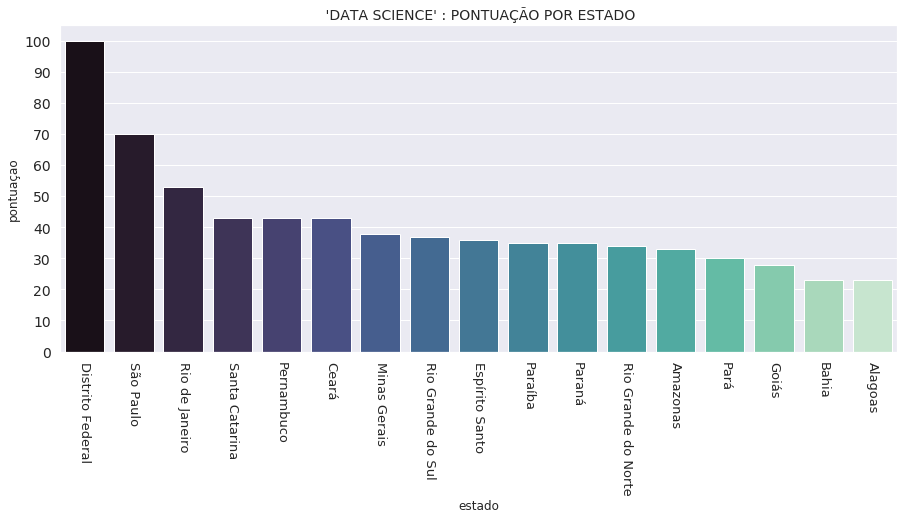

In [261]:
try:
    #rolar a página até o outro botão estar visível
    driver.execute_script("window.scrollTo(0, {});".format(500))

    #clicar no segundo botão de baixar o csv, logo após estar visível
    second_button =driver.find_elements_by_xpath("""//*[@class="widget-actions-item export"]""")[1]
    second_button.click()

    #esperar baixar o .csv
    time.sleep(1)

    # obter o arquivo mais recente na pasta Downloads
    csv2 = arquivo_recente(download_path)

    #instanciar o segundo dataframe passando o caminho do csv mais recente
    DF_GEOMAP = pd.read_csv(csv2 , names=['estado','pontuaçao']).iloc[2:].reset_index(drop=True)

    #plotar gráfico da pontuação por estado
    if DF_GEOMAP.shape[0] != 0:   
        plotar(DF_GEOMAP,'geo',pesquisa)
        
    else:
        print("DADOS INSUFICIENTES PARA PLOTAGEM \n")
    
    # fechar o browser
    driver.quit()
    
except Exception as e:
    print(e)
    pass